# Exploratory data analysis

### Module loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re

#machine learning models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import train_test_split

### Ideas

* Include a feature that captures if more people were in the cabin for instance

## Data loading

In [4]:
whole_data = pd.read_csv("raw_data/train.csv")

In [5]:
whole_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Create holdout set

In [18]:
data, holdout = train_test_split(whole_data, test_size=0.2, random_state = 42)

In [20]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,NaN,S
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S


## Feature analysis

First, lets look at the initial features

### Passenger ID

In [21]:
data.PassengerId.describe()

count    712.000000
mean     448.234551
std      256.731423
min        1.000000
25%      224.750000
50%      453.500000
75%      673.500000
max      891.000000
Name: PassengerId, dtype: float64

In [22]:
data.PassengerId = data.PassengerId.astype("category")

/home/adri/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [25]:
# Check if all the passengerIds are unique
data["PassengerId"].value_counts().value_counts()

1    712
Name: PassengerId, dtype: int64

All passenger Ids are unique.

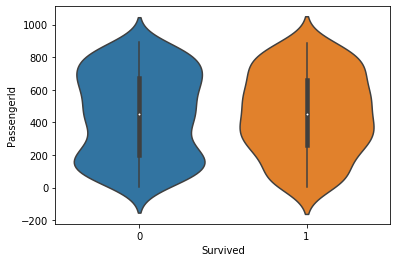

In [26]:
# Check if there is any relationship between survival and passenger IDs
sns.violinplot(x="Survived", y="PassengerId", data=data, orient="v")
plt.show()

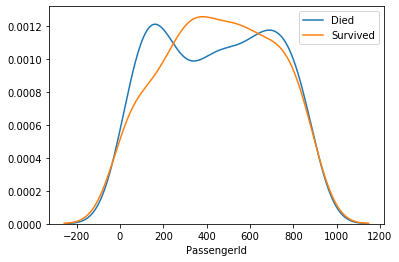

In [27]:
sns.distplot(data.PassengerId[data.Survived == 0], hist = False, label = "Died")
sns.distplot(data.PassengerId[data.Survived == 1], hist = False, label = "Survived")
plt.show()

In general it seems that there is no tendency relating passenger ID with survival

### Survived

In [28]:
data.Survived = data.Survived.astype("category")

In [29]:
data.Survived.value_counts(normalize=True)

0    0.623596
1    0.376404
Name: Survived, dtype: float64

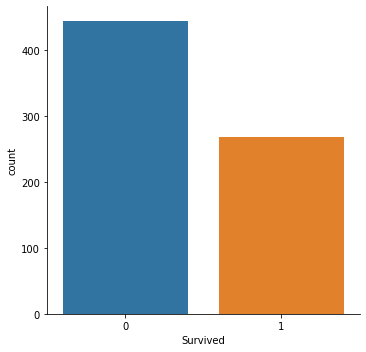

In [30]:
sns.catplot(x="Survived", kind="count", data=data)
plt.show()

Aproximately a 60% of the passengers died in the titanic and 40% survived. Probably the dataset is balanced enough to not include weights in the model.

### Pclass

In [31]:
data.Pclass = data.Pclass.astype("category")

In [32]:
data.Pclass.value_counts(normalize=True)

3    0.558989
1    0.228933
2    0.212079
Name: Pclass, dtype: float64

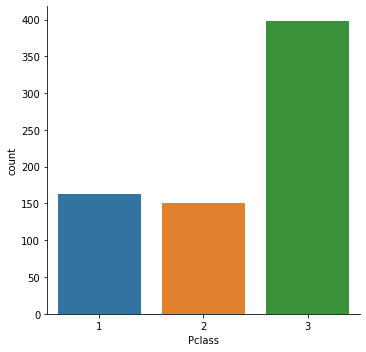

In [33]:
sns.catplot("Pclass", data = data, kind="count")

Passenger class is not balanced, 55% of the people where 3rd class, the rest is similarly balanced between 1st and 2nd class. 

In [34]:
data.groupby("Pclass").Survived.value_counts(normalize=True)

Pclass  Survived
1       1           0.607362
        0           0.392638
2       0           0.516556
        1           0.483444
3       0           0.758794
        1           0.241206
Name: Survived, dtype: float64

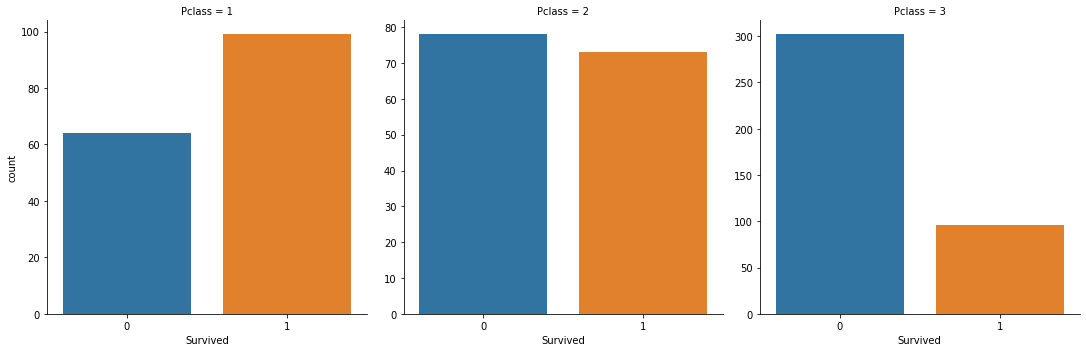

In [35]:
sns.catplot(col="Pclass", data = data, x="Survived", kind="count",sharey=False )

The frequency of survival is highly dependent on the passenger class. While in 3rd class people had 75% chances of dying, in 2nd it is a 52% and in 1st it is only a 37% chances. Therefore, The higher the class the more chances to survive.

### Name
Although there is some usefull information in the name field we will process this field later in the notebook. First, I will try to set a baseline using the simplest features in the initial dataset. 

### Sex

In [36]:
data.Sex = data.Sex.astype("category")

In [37]:
data.Sex.value_counts(normalize=True)

male      0.655899
female    0.344101
Name: Sex, dtype: float64

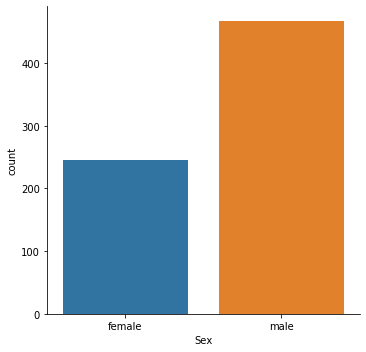

In [38]:
sns.catplot("Sex", data = data, kind="count")

Regarding Sex, 64% of the passengers where males.

In [39]:
data.groupby("Sex").Survived.value_counts(normalize=True)

Sex     Survived
female  1           0.738776
        0           0.261224
male    0           0.813704
        1           0.186296
Name: Survived, dtype: float64

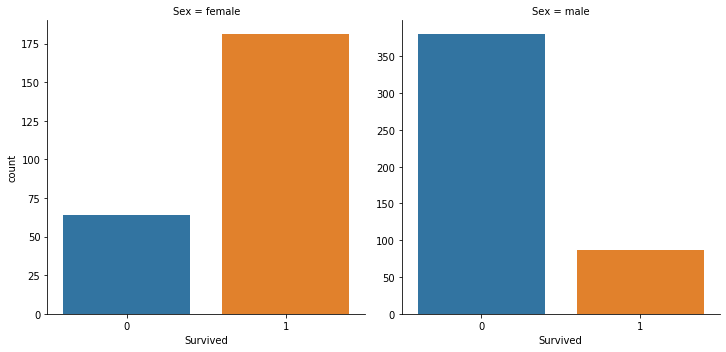

In [40]:
sns.catplot(col="Sex", data = data, x="Survived", kind="count", sharey=False )

Again, the survival rate is quite different between the two clases. A woman had 74% chances of surviving, while mens had 81% chances of perishing. It seems that class and sex are going to be quite important in predicting survival. Let's see if there is any kind of interaction between the two features. 

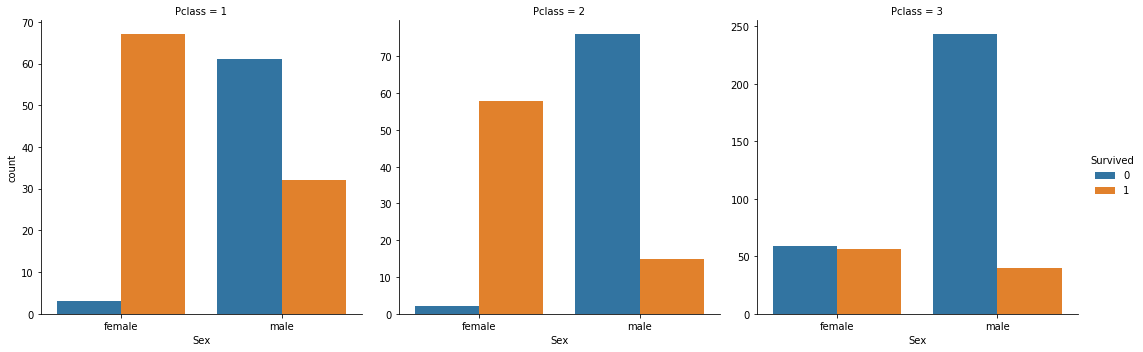

In [41]:
sns.catplot(x="Sex",col="Pclass", hue="Survived", kind="count", data = data, sharey=False)

It is evident that there is some interaction between the two variables. While being a woman of 1st or 2nd class  practically enures survival, womens of the 3rd class had the same chances of dying than surviving. Regarding men, survival rate is similar between males of 3rd and 2nd class. However, the forecast improves in 1st class men. 

### Age

In [42]:
data.Age.describe()

count    572.000000
mean      29.498846
std       14.500059
min        0.420000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

There is 177 (891-714) Passengers without age information. Mmaybe we can try to inputate the age based on closest neightbours. 

In [43]:
data.Age[data.Age < 1]

305    0.92
644    0.75
469    0.75
803    0.42
755    0.67
831    0.83
Name: Age, dtype: float64

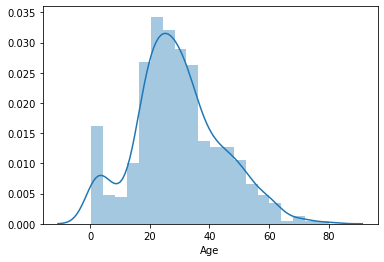

In [44]:
sns.distplot(data.Age.dropna())

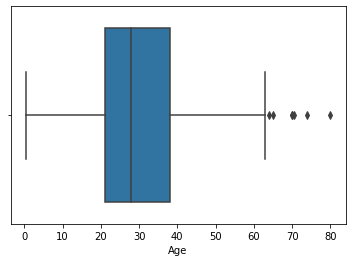

In [45]:
sns.boxplot("Age", data = data)

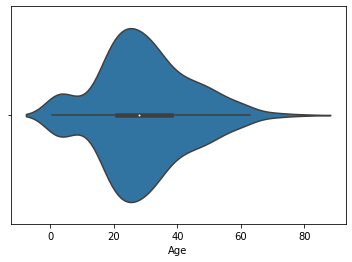

In [46]:
sns.violinplot("Age", data = data)

The distribution of age has a bell shape squed to the right. Also there is a small peak of frequency in babies that do not follow this bellshape. Some of the passengers fall out of the IQR, They are probably good candidates for outliers removal. 

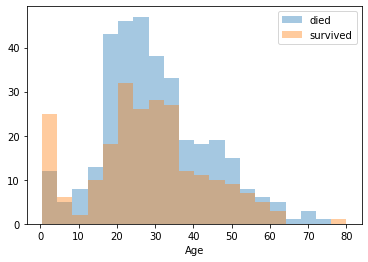

In [55]:
bins=np.histogram(data.Age.dropna(), bins=20)[1] #get the bin edges

sns.distplot(data.Age[data.Survived == 0].dropna(), kde = False, label="died", bins=bins)
sns.distplot(data.Age[data.Survived == 1].dropna(), kde = False, label="survived", bins=bins)
plt.legend()

By looking at the distribution of Age between survivors and non-survivors it seems that Age is also important in terms of survival. Kids from 0 to 5 years are the ones with more chance of surviving. Old people from 65 to 75 have less chances of survival, however, low numbers in this range makes this data of less informative. After this group, people between 15 and 30 have more chances of diying. The rest of people have slightly more chances of dying but being close to 50-50 situation

### SibSp

In [ ]:
data.SibSp.describe()

In [ ]:
data.SibSp.value_counts()

In [ ]:
sns.catplot("SibSp", kind="count", data=data)

Almost all the people have either 0 or 1 sibling or spoutse on board. Only a few people had 2 or more. This low numbers could add some noice to our model. We could consider bucketizing categoires from 2 to 8 in a single one in order to capture common features between this group with some statistical confidence.

In [ ]:
data.groupby("SibSp")["Survived"].value_counts(normalize=True)

In [ ]:
sns.catplot("Survived", kind="count",col="SibSp",col_wrap=4, sharey = False, data=data)

It seems that having 1 or 2 spouse and or siblings increse survival chances in comparison with other groups. All the people with 5 or more spouse+siblings died, however lets keep in mind the low N of this groups. for the other groups survival rates range from 16 in the case of 4% sibsp to 34% in the case of 0

### Parch

Parch correspond to the number of parents and or children that a passenger had onboard. I am going to treat is as a categorical variable

In [ ]:
pd.concat([data.Parch.value_counts(), data.Parch.value_counts(
    normalize=True)*100], axis=1)

In [ ]:
sns.catplot("Parch", kind="count", data=data)

Almost all the people, have from 0 to 2 first degree familiars in the titanic. From those, the biggest group is the people without any pared or offspring with a 76% of the passengers in this group. 

In [ ]:
sns.catplot(col="Parch", kind="count", data=data, x="Survived", sharey=False, col_wrap=4)

keeping in mind that the frequncies for people with 3 or more parents or children are not trustable, due to low numbers, it seems that having 1 or two familiars of that kind is quite beneficial for survival. Probably it should be considered to remove the minoritary clases to reduce noise in the dataset. 

### Ticket
For the same reason than the name, I will leave ticket for later

### Fare
Probably, Fare will be quite correlated to class. Therefore we may want to keep only one of the two features for modeling

In [ ]:
data.Fare.describe()

There is no Nan in this feature, however, the minimal value is 0. This can be due to represent not available data as 0 and for the members of the crew.

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(data.Fare)

In [ ]:
sns.boxplot("Fare", data = data)

In [ ]:
sns.violinplot("Fare", data = data)

It seems that the distribution is quite squed to the right. 75 % of the values are between 7 and 31. Lets see the correlation with pclass

In [ ]:
sns.boxplot(x = "Pclass", y = "Fare", data = data[data.Fare < 300])

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.distplot(data[(data.Fare < 300) & (data.Pclass == 1)]["Fare"])
sns.distplot(data[(data.Fare < 300) & (data.Pclass == 2)]["Fare"])
sns.distplot(data[(data.Fare < 300) & (data.Pclass == 3)]["Fare"])

The distributions aer clearly different between the three groups. Surprisingly, it seems that there is quite overlaping of the clases. There is people from 3rd class that pays the same than people from 1st class. Let's look at its interaction with survival

In [ ]:
sns.catplot("Survived", "Fare", data=data[data.Fare < 300], kind="violin")

In [ ]:

sns.catplot(x="Fare", y="Pclass",
               data=data[data.Fare < 300], hue="Survived", split=True, kind="violin", height=10, orient="h")

As for first class it seems that the fare have a moderate effect in the main bulk of data points. The distribution of survivors is slighly higher that non survivors. In the case of 2nd class, there is a second peak in the distribution of survivors that affects the survival rate for higher fares. Finaly for 1st class it does not seem to be any difference between the two distributions in the main bulk. 

There is a phenomenon in the second and third lcass in the top values apparently in booth cases, the top Fares were more likely to die, however, submaximal fares had more chances to survive.

It seems that Fare is not as informative as previous features analyzed

### Cabin

In [ ]:
data.Cabin.describe()

In [ ]:
data.Cabin.isna().sum()

There are 147 different cabins, some of them are shared as the total number of not nan values are 204. The max frequency is 4 so the cabins with more capacity where thought for 4 people. There are 687 people without cabin. 

In [ ]:
data.Cabin[data.Cabin.notna()].values

Looking at the values, it seems that cabins are named with a letter and an optional number. Also, there is people with more than one room in their record. For the sake of simplicity, In this first round of analysis I will take Cabin as a boolean feature, being 0 if nan and 1 otherwise. 

In [ ]:
data["boolean_cabin"] = data.Cabin.notna()

In [ ]:
data.boolean_cabin = data.boolean_cabin.astype("category")

In [ ]:
data.groupby("boolean_cabin")["Survived"].value_counts(normalize=True)

In [ ]:
sns.catplot(x="boolean_cabin", hue="Survived", kind = "count", data = data)

Only taking into account the boolean cabin there is already a quite important difference in survival ratio. Not having a cavinet results in a 70% chances of diying, while having one increases your survival chances to 66%. Like in the case of the fare, Probably there is a high correlation with the passenger class.

In [ ]:
sns.catplot("boolean_cabin", kind="count", data=data, hue="Pclass")

Almost all the people in cavins are from 3rd class. Surprisingly there are people from all classes in the two groups. on the other hand almost all the people from second and third class does not have a cabin. Closer inspection must be done to uncommon cases to discard possible outlayers. 

In [ ]:
sns.catplot( "Fare","boolean_cabin", kind="violin", data=data, orient="h",aspect=2)

As espected, there is a difference in the fare of people with and without cabin

### Embarked

In [ ]:
data.Embarked = data.Embarked.astype("category")

In [ ]:
data.Embarked.describe()

In [ ]:
pd.concat([data.Embarked.value_counts(), data.Embarked.value_counts(
    normalize=True)*100], axis=1)

In [ ]:
data.Embarked.isna().sum()

In [ ]:
sns.catplot("Embarked", kind="count", data=data)

We see that Embarked is unevenly distributed, 72% of the whole people embarked in "S". There are two Nans in the feature, we could remove them or imput the value based on the rest of the features. 

In [ ]:
sns.catplot(col="Embarked", kind="count", data=data, x="Survived", sharey=False)

The survival rate is considerably affected by the embarking logation. Embarking in C makes it more probable to survive. on the contrary embarking in  in q or s have higher and similar probabliity to die. 

## Preparing the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler


In [ ]:
data = data.dropna()

In [ ]:
X = data.drop(["Survived", "Cabin", "PassengerId", "Name", "Ticket"], axis=1)
y = data.Survived

In [ ]:
X

In [ ]:
X = pd.get_dummies(X)

In [ ]:
# Scaling dataframe
x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=X.columns)

In [ ]:
X.head()

In [ ]:
y.head()

## Baseline model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn import tree, svm
from sklearn import preprocessing

### Logistic regression

In [ ]:
kf = KFold(n_splits=5,shuffle=True)

f1_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = LogisticRegression(solver="lbfgs", max_iter=300).fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, pred)
    
    f1_list.append(f1)
    print(f"{f1:.3}")
    
f1_mean = np.mean(f1_list)
f1_sd = np.std(f1_list)
print(f"result: {f1_mean:.3} +- {f1_sd:.3}")


### Decision Tree

In [ ]:
kf = KFold(n_splits=5,shuffle=True)

f1_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = tree.DecisionTreeClassifier(max_depth=4)
    clf = clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, pred)
    
    f1_list.append(f1)
    print(f"{f1:.3}")
    
f1_mean = np.mean(f1_list)
f1_sd = np.std(f1_list)
print(f"result: {f1_mean:.3} +- {f1_sd:.3}")

### SVM

In [ ]:
kf = KFold(n_splits=5,shuffle=True)

f1_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = svm.SVC(gamma='scale')
    clf = clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    
    f1 = f1_score(y_test, pred)
    
    f1_list.append(f1)
    print(f"{f1:.3}")
    
f1_mean = np.mean(f1_list)
f1_sd = np.std(f1_list)
print(f"result: {f1_mean:.3} +- {f1_sd:.3}")

## Feature Engineering

### Name

In [ ]:
# Extracting the family name
data["family_name"] = data.Name.apply(lambda x: re.findall("(.*),", x)[0])

In [ ]:
# Extracting title
data["title"] = data.Name.apply(lambda x: re.findall("(\w*)\.", x)[0])

In [ ]:
# Extracting text between parenthesis
parenthesis = data.Name.apply(lambda x: re.findall("\((.*)\)", x))
data["parenthesis"] = parenthesis.apply(lambda x: x[0] if x else np.nan)

In [ ]:
# extracting the given name
given_name = data.Name.apply(lambda x: re.findall("\. (.+?)( \(|$)", x))
data["given_name"] = given_name.apply(lambda x: x[0][0] if x else np.nan)

In [ ]:
# cuotes

cuotes = data.Name.apply(lambda x: re.findall('\"(.*)\"', x))
data["cuotes"] = cuotes.apply(lambda x: x[0] if x else np.nan)